# Topic Modeling

In [66]:
from tmtoolkit.corpus import Corpus, lemmatize, to_lowercase, remove_chars, filter_clean_tokens, remove_punctuation
from tmtoolkit.corpus import corpus_num_tokens, corpus_tokens_flattened
from tmtoolkit.corpus import dtm
from tmtoolkit.corpus import vocabulary
from tmtoolkit.topicmod.model_io import print_ldamodel_topic_words
from tmtoolkit.topicmod.tm_lda import compute_models_parallel
from tmtoolkit.topicmod.tm_lda import evaluate_topic_models
from tmtoolkit.topicmod.evaluate import results_by_parameter

## Data Loading

The dataset is open source dataset to fine-tunine foundation language model to follow instruction.

In [67]:
import json

instruction_examples = []

with open('./wizardlm_alpaca_dolly_orca.jsonl', 'r') as file:
    for line in file:
        data = json.loads(line)
        instruction_examples.append(data)

In [68]:
len(instruction_examples)

104179

The instruction example is to teach the language model to follow the instruction. Basically, it is the instruction e.g., "What are the three primary colors?". We want to teach LLM (Large Language Model) to answer our question instead of generating what LLM normally generate. In the actual training, we pad the text with special tokens (###).

```
### Instruction:
Who are you?

### Output:
I am AI chat model. May I know how I can help you?
```


In [69]:
instruction_examples[0]

{'instruction': 'What are the three primary colors?',
 'input': '',
 'system': 'You are a teacher. Given a task, you explain in simple steps what the task is asking, any guidelines it provides and how to use those guidelines to find the answer.',
 'output': 'The task is asking for the three primary colors. Primary colors are colors that cannot be created by mixing other colors together. The guidelines that we have is that we need to identify the three primary colors. \n\nTo find the answer, we need to know that there are two sets of primary colors: additive and subtractive. Additive primary colors are red, green, and blue. These are the primary colors of light and are used in devices such as computer monitors and televisions. Subtractive primary colors are cyan, magenta, and yellow, which are the primary colors of pigments and are used in printing. \n\nHowever, the most commonly known primary colors are red, blue, and yellow, which are the primary colors for mixing paints. So, to answe

The system message is the header that is telling the model what the model needs to behaviour and it comes with 15 system messages to choose from. For the purpose of topic modeling, we will be only interested in `instruction` and `output` because we want to visualize what training dataset topics are distributed.

In [70]:
instruction_texts = [example['instruction'] + ' ' + example['output'] for example in instruction_examples]

## EDA

In [71]:
instruction_texts[0]

'What are the three primary colors? The task is asking for the three primary colors. Primary colors are colors that cannot be created by mixing other colors together. The guidelines that we have is that we need to identify the three primary colors. \n\nTo find the answer, we need to know that there are two sets of primary colors: additive and subtractive. Additive primary colors are red, green, and blue. These are the primary colors of light and are used in devices such as computer monitors and televisions. Subtractive primary colors are cyan, magenta, and yellow, which are the primary colors of pigments and are used in printing. \n\nHowever, the most commonly known primary colors are red, blue, and yellow, which are the primary colors for mixing paints. So, to answer the question, the three primary colors are red, blue, and yellow.'

In [72]:
from wordcloud import STOPWORDS

In [73]:
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

### Unigram

In [74]:
from collections import defaultdict

unigram = defaultdict(int)

for example in instruction_texts:
    for word in generate_ngrams(example, 1):
        unigram[word] += 1

In [75]:
import pandas as pd

df_unigram = pd.DataFrame(sorted(unigram.items(), key=lambda x: x[1])[::-1])

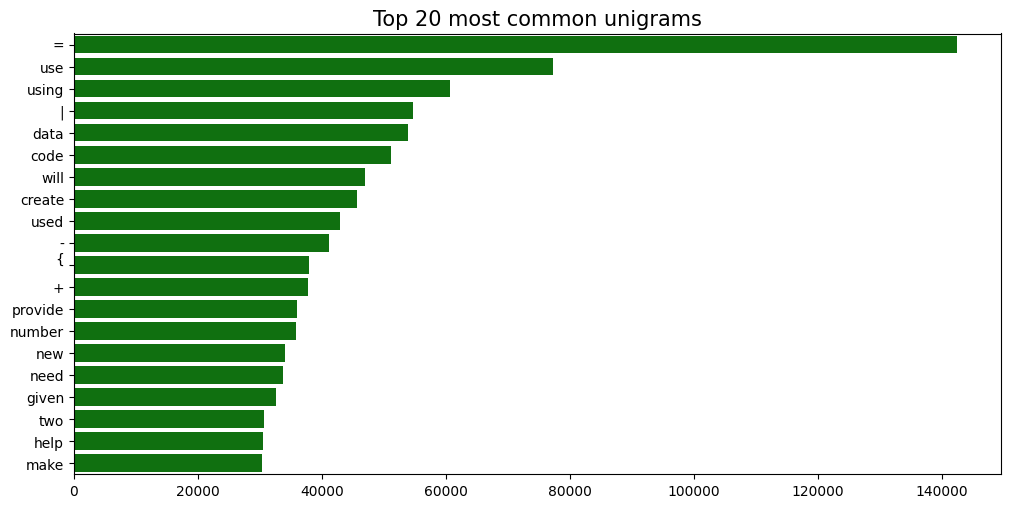

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns

N = 20

fig, axes = plt.subplots(ncols=1, figsize=(10, 5))
plt.tight_layout()

sns.barplot(y=df_unigram[0].values[:N], x=df_unigram[1].values[:N], ax=axes, color='green')

axes.set_title(f'Top {N} most common unigrams', fontsize=15)


plt.show()

### Bigrams

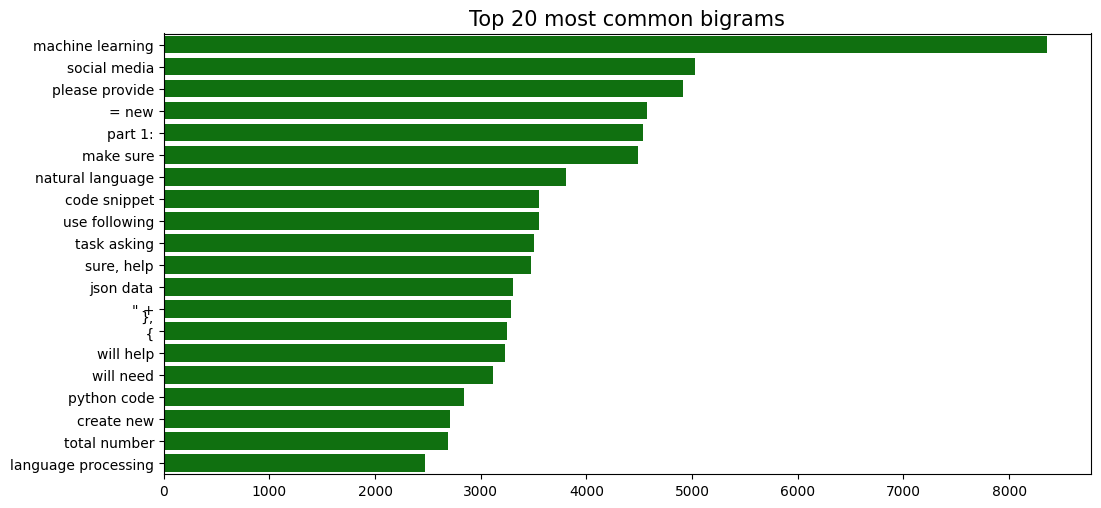

In [77]:
bigrams = defaultdict(int)

for example in instruction_texts:
    for word in generate_ngrams(example, 2):
        bigrams[word] += 1
        
df_bigrams = pd.DataFrame(sorted(bigrams.items(), key=lambda x: x[1])[::-1])

N = 20

fig, axes = plt.subplots(ncols=1, figsize=(10, 5))
plt.tight_layout()

sns.barplot(y=df_bigrams[0].values[:N], x=df_bigrams[1].values[:N], ax=axes, color='green')

axes.set_title(f'Top {N} most common bigrams', fontsize=15)


plt.show()

### Trigrams

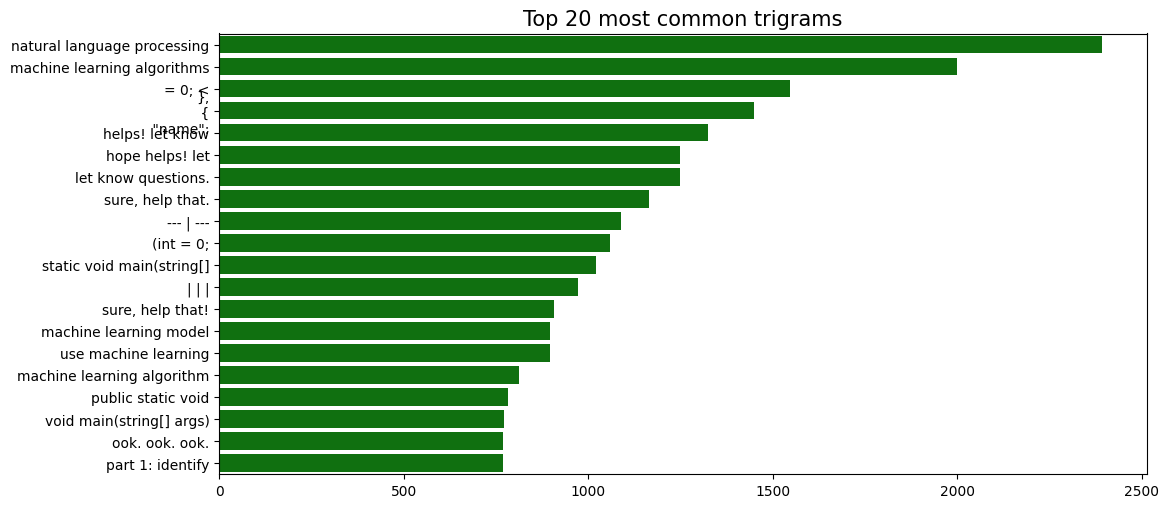

In [78]:
trigrams = defaultdict(int)

for example in instruction_texts:
    for word in generate_ngrams(example, 3):
        trigrams[word] += 1
        
df_trigrams = pd.DataFrame(sorted(trigrams.items(), key=lambda x: x[1])[::-1])

N = 20

fig, axes = plt.subplots(ncols=1, figsize=(10, 5))
plt.tight_layout()

sns.barplot(y=df_trigrams[0].values[:N], x=df_trigrams[1].values[:N], ax=axes, color='green')

axes.set_title(f'Top {N} most common trigrams', fontsize=15)


plt.show()

### Building text corpus

In [79]:
def build_corpus(texts, lang="en"):
    corpus = Corpus({ i:r for i, r in enumerate(texts) }, language=lang)

    lemmatize(corpus)
    to_lowercase(corpus)
    remove_punctuation(corpus)
    filter_clean_tokens(corpus, remove_shorter_than=2)

    return corpus

In [80]:
instruction_corpus = build_corpus(instruction_texts)

In [81]:
var_params = [{ 'n_topics': k, 'alpha': 1 / k } for k in range(10, 71, 10)]

const_params = {
    'n_iter': 100,
    'random_state': 42,
    'eta': 0.7
}

In [82]:
document_term_matrix, doc_labels_, vocab_ = dtm(instruction_corpus, return_doc_labels=True, return_vocab=True)

## Evaluating different parameters

In [ ]:
eval_results = evaluate_topic_models(
    document_term_matrix,
    varying_parameters=var_params,
    constant_parameters=const_params,
    coherence_mimno_2011_top_n=10,
    coherence_mimno_2011_include_prob=True,
    return_models=True
)

In [84]:
eval_results_by_topics = results_by_parameter(eval_results, 'n_topics')
eval_results_by_topics[:3]

[(10,
  {'model': <lda.lda.LDA at 0x7f3d5850c4c0>,
   'cao_juan_2009': 0.2769648237624434,
   'coherence_mimno_2011': -508.87131174965197}),
 (20,
  {'model': <lda.lda.LDA at 0x7f3d587afa90>,
   'cao_juan_2009': 0.15475254623499843,
   'coherence_mimno_2011': -522.2826978615731}),
 (30,
  {'model': <lda.lda.LDA at 0x7f3d587af2b0>,
   'cao_juan_2009': 0.1287735712779849,
   'coherence_mimno_2011': -538.8720506162031})]

/home/light/anaconda3/envs/topic_model/lib/python3.10/site-packages/tmtoolkit/topicmod/visualize.py:833: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(**subplots_adjust_kwargs)


(<Figure size 600x400 with 2 Axes>,
 [array([<Axes: title={'center': 'cao_juan_2009'}>,
         <Axes: title={'center': 'coherence_mimno_2011'}>], dtype=object)])

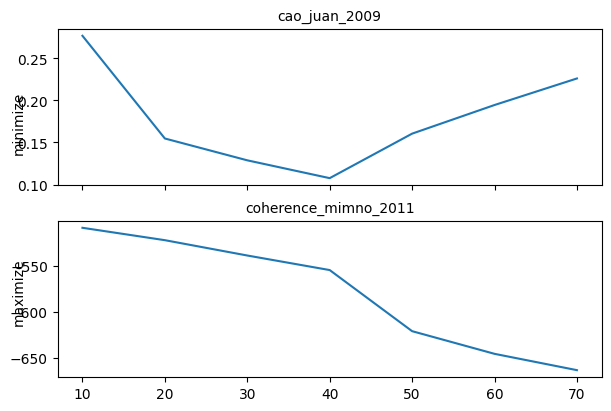

In [85]:
from tmtoolkit.topicmod.visualize import plot_eval_results

plot_eval_results(eval_results_by_topics)

### Best Topic Model

In [86]:
best_tm = [m for k, m in eval_results_by_topics if k == 30][0]['model']
best_tm.n_topics, best_tm.alpha, best_tm.eta

(30, 0.03333333333333333, 0.7)

### Generating topic words

In [87]:
import numpy as np

from tmtoolkit.bow.bow_stats import doc_lengths
from tmtoolkit.topicmod.model_stats import generate_topic_labels_from_top_words

vocab_ = np.array(vocab_)

doc_lengths_bg = doc_lengths(document_term_matrix)
topic_labels = generate_topic_labels_from_top_words(
    best_tm.topic_word_,
    best_tm.doc_topic_,
    doc_labels_,
    np.array(vocab_),
    lambda_=2.0
)

In [88]:
topic_labels

array(['1_step_1_2_3', '2_help_2_1_3', '3_2_1_use_3', '4_1_2_3_number',
       '5_time_find_like_help', '6_change_1_people_2',
       '7_use_reduce_help_1', '8_help_1_2_3', '9_1_2_3_4',
       '10_word_sentence_give_1', '11_datum_use_task_1', '12_1_2_water_3',
       '13_create_word_use_2', '14_1_2_3_use', '15_animal_1_find_2',
       '16_1_2_3_city', '17_country_1_world_2', '18_use_datum_1_2',
       '19_day_year_month_date', '20_cat_dog_pet_animal',
       '21_2_1_3_number', '22_game_play_team_player',
       '23_joke_sentence_1_2', '24_create_text_add_example',
       '25_1_book_3_2', '26_2_give_1_find',
       '27_movie_character_include_follow',
       '28_sentence_word_give_follow', '29_french_english_translate_mean',
       '30_know_world_include_time'], dtype='<U33')

### Result Discussion

According to this topic, it makes sense because I have a general idea of what training dataset look like. The dataset is used to teach the language model to do story telling, writing and reading comprehension. And, half of the data is writing code though I believe, some part of that will be removed by preprocessing.

In [89]:
from tmtoolkit.topicmod.model_io import ldamodel_top_topic_words

top_topic_word = ldamodel_top_topic_words(
    best_tm.topic_word_,
    vocab_,
    row_labels=topic_labels
)

In [90]:
top_topic_word[:10]

,rank_1,rank_2,rank_3,rank_4,rank_5,rank_6,rank_7,rank_8,rank_9,rank_10
topic,,,,,,,,,,
1_step_1_2_3,customer (0.02023),step (0.01603),product (0.01251),create (0.0104),help (0.00925),service (0.009005),website (0.008957),provide (0.008611),2 (0.00856),1 (0.008499)
2_help_2_1_3,help (0.02066),health (0.01481),reduce (0.0111),improve (0.01035),exercise (0.00915),stress (0.007913),healthy (0.007237),disease (0.007138),benefit (0.007132),patient (0.006823)
3_2_1_use_3,item (0.01439),food (0.009807),fruit (0.00973),plant (0.008227),apple (0.007053),use (0.00695),water (0.006802),need (0.006699),list (0.005828),2 (0.005415)
4_1_2_3_number,number (0.02153),1 (0.01993),list (0.01562),string (0.01418),2 (0.01376),function (0.01341),3 (0.01281),code (0.01169),element (0.01163),return (0.01102)
5_time_find_like_help,story (0.0123),time (0.01011),day (0.009603),like (0.007954),find (0.007673),know (0.007635),friend (0.007391),way (0.005897),love (0.005872),new (0.005581)
6_change_1_people_2,change (0.01377),impact (0.01114),increase (0.008782),climate (0.008184),lead (0.008024),economic (0.006762),article (0.006473),cause (0.00637),global (0.006236),significant (0.006225)
7_use_reduce_help_1,energy (0.02533),reduce (0.02376),car (0.02006),use (0.01364),waste (0.008846),water (0.008182),transportation (0.008006),help (0.007739),source (0.00662),renewable (0.006594)
8_help_1_2_3,work (0.01258),help (0.009815),student (0.008875),skill (0.007957),time (0.006929),learn (0.006822),job (0.006145),provide (0.005841),1 (0.005679),2 (0.005508)
9_1_2_3_4,1 (0.01511),2 (0.01181),ingredient (0.01148),add (0.01059),cup (0.008165),dish (0.007941),recipe (0.007875),3 (0.00782),cook (0.00678),egg (0.006511)


In [91]:
from tmtoolkit.topicmod.visualize import parameters_for_ldavis

ldavis_params = parameters_for_ldavis(
    best_tm.topic_word_,
    best_tm.doc_topic_,
    document_term_matrix,
    vocab_
)

In [92]:
from tmtoolkit.topicmod.evaluate import metric_coherence_mimno_2011

coh = metric_coherence_mimno_2011(
    best_tm.topic_word_,
    document_term_matrix,
    top_n=10,
    include_prob=True
)
coh

array([-459.19549163, -512.19823196, -509.47114343, -473.50612528,
       -514.03598743, -530.26555532, -493.72100587, -504.6432425 ,
       -513.19870906, -487.6398452 , -448.65872983, -566.90808182,
       -538.93643942, -547.96503675, -537.75981173, -519.27833565,
       -521.08741281, -502.17116336, -632.94185673, -626.48427109,
       -428.51743031, -516.9931649 , -799.75497688, -554.56944938,
       -598.88391768, -508.62005077, -582.94122482, -490.34995661,
       -665.92030982, -579.54456048])

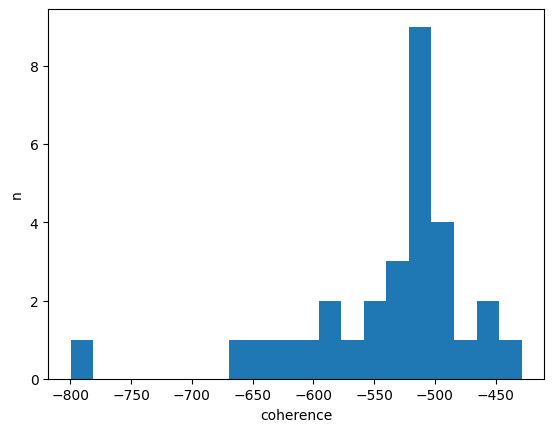

In [93]:
import matplotlib.pyplot as plt

plt.hist(coh, bins=20)
plt.xlabel('coherence')
plt.ylabel('n')
plt.show()

In [94]:
import pyLDAvis

In [95]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.prepare(**ldavis_params)

In [96]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.262290 -0.001771       1        1  11.172034
1      0.105440  0.069663       2        1   4.037306
2      0.042187 -0.024371       3        1   3.072720
3      0.087940 -0.199772       4        1   4.971460
4      0.096664  0.125194       5        1   7.573171
5      0.088095  0.105171       6        1   4.114986
6      0.055314  0.040074       7        1   3.038813
7      0.219402  0.086629       8        1   8.172878
8      0.020498 -0.098475       9        1   4.207744
9      0.054641 -0.083808      10        1   3.224873
10     0.162350 -0.012002      11        1   5.678227
11     0.026036  0.029190      12        1   3.404320
12     0.048075  0.047033      13        1   4.043114
13    -0.035262  0.001961      14        1   1.570618
14    -0.032576  0.023279      15        1   2.421643
15    -0.027845  0.065147      16        1   2.834596
16    -0.087471  0.019143      17        1   2.169010
17     0.161853  0.003616      18        1   5.605203
18    -0.181408  0.003750      19        1   0.234533
19    -0.182571  0.001958      20        1   0.269839
20     0.047467 -0.233868      21        1   4.581667
21    -0.089368  0.032681      22        1   1.814892
22    -0.182612 -0.002969      23        1   0.085771
23    -0.145751 -0.024575      24        1   0.640115
24    -0.037923  0.083450      25        1   3.069667
25    -0.060035 -0.151719      26        1   2.000487
26    -0.140296  0.047225      27        1   1.160174
27     0.030994 -0.028956      28        1   3.073400
28    -0.185161 -0.003510      29        1   0.188257
29    -0.120965  0.080633      30        1   1.568482, topic_info=           Term          Freq         Total Category  logprob  loglift
48041  sentence  12552.000000  12552.000000  Default  30.0000  30.0000
58236      word  10343.000000  10343.000000  Default  29.0000  29.0000
16976     datum  10266.000000  10266.000000  Default  28.0000  28.0000
38031    number  10215.000000  10215.000000  Default  27.0000  27.0000
16519  customer   8546.000000   8546.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
28071   include    182.134736   9793.816222  Topic30  -5.7607   0.1703
53892      time    141.816171  11509.651836  Topic30  -6.0109  -0.2413
15119  consider    114.352800   3237.323910  Topic30  -6.2262   0.8118
24957     great    112.015492   4252.774424  Topic30  -6.2468   0.5184
31684      lead    106.756549   3680.055675  Topic30  -6.2949   0.6149

[1895 rows x 6 columns], token_table=       Topic      Freq Term
term                       
0          1  0.000778    0
0          2  0.000389    0
0          3  0.000389    0
0          4  0.541504    0
0          5  0.000389    0
...      ...       ...  ...
59512     18  0.011293    π
59512     21  0.011293    π
59512     25  0.011293    π
59512     26  0.846990    π
59512     28  0.011293    π

[32009 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

### Conclusion

In conclusion, the model performs well. The visualization is quite insightful. It really helps me to make sense of the dataset.
The topic 1 seems to be related to marketing.<br>
The topic 12 is about physics.<br>
Topic 4 is about coding<br>
These are a few explanation of the topics from the visualization.<br>
Overall, I think the model is quite good. It is able to capture the main topics of the dataset.


In the future work, I would try to incorporate with more datasets and try to tune the parameters to get better results. I would also try to use other topic modeling methods to see if I can get better results. At the model, I also explored with BERT Topic. Please refer to the bert notebook.